# Flood prediction regression

Flood prediction regression from kaggle https://www.kaggle.com/competitions/playground-series-s4e5

In [4]:
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
import catboost as cb

## Load and inspect dataset

In [6]:
df = pd.read_csv('train.csv')

In [7]:
df.head()

id  MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0   0                 5                   8                5              8   
1   1                 6                   7                4              4   
2   2                 6                   5                6              7   
3   3                 3                   4                6              5   
4   4                 5                   3                2              6   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             6              4            4          3                      3   
1             8              8            3          5                      4   
2             3              7            1          5                      4   
3             4              8            4          7                      6   
4             4              4            3          3                      3   

   ...  DrainageSystems  CoastalVulnerability  Landslides  Watersheds  \
0  ...                5                     3           3           5   
1  ...                7                     2           0           3   
2  ...                7                     3           7           5   
3  ...                2                     4           7           4   
4  ...                2                     2           6           6   

   DeterioratingInfrastructure  PopulationScore  WetlandLoss  \
0                            4                7            5   
1                            5                3            3   
2                            6                8            2   
3                            4                6            5   
4                            4                1            2   

   InadequatePlanning  PoliticalFactors  FloodProbability  
0                   7                 3             0.445  
1                   4                 3             0.450  
2                   3                 3             0.530  
3                   7                 5             0.535  
4                   3                 5             0.415  

[5 rows x 22 columns]

In [8]:
print(df.isnull().sum())

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64


There are no missing data to deal with

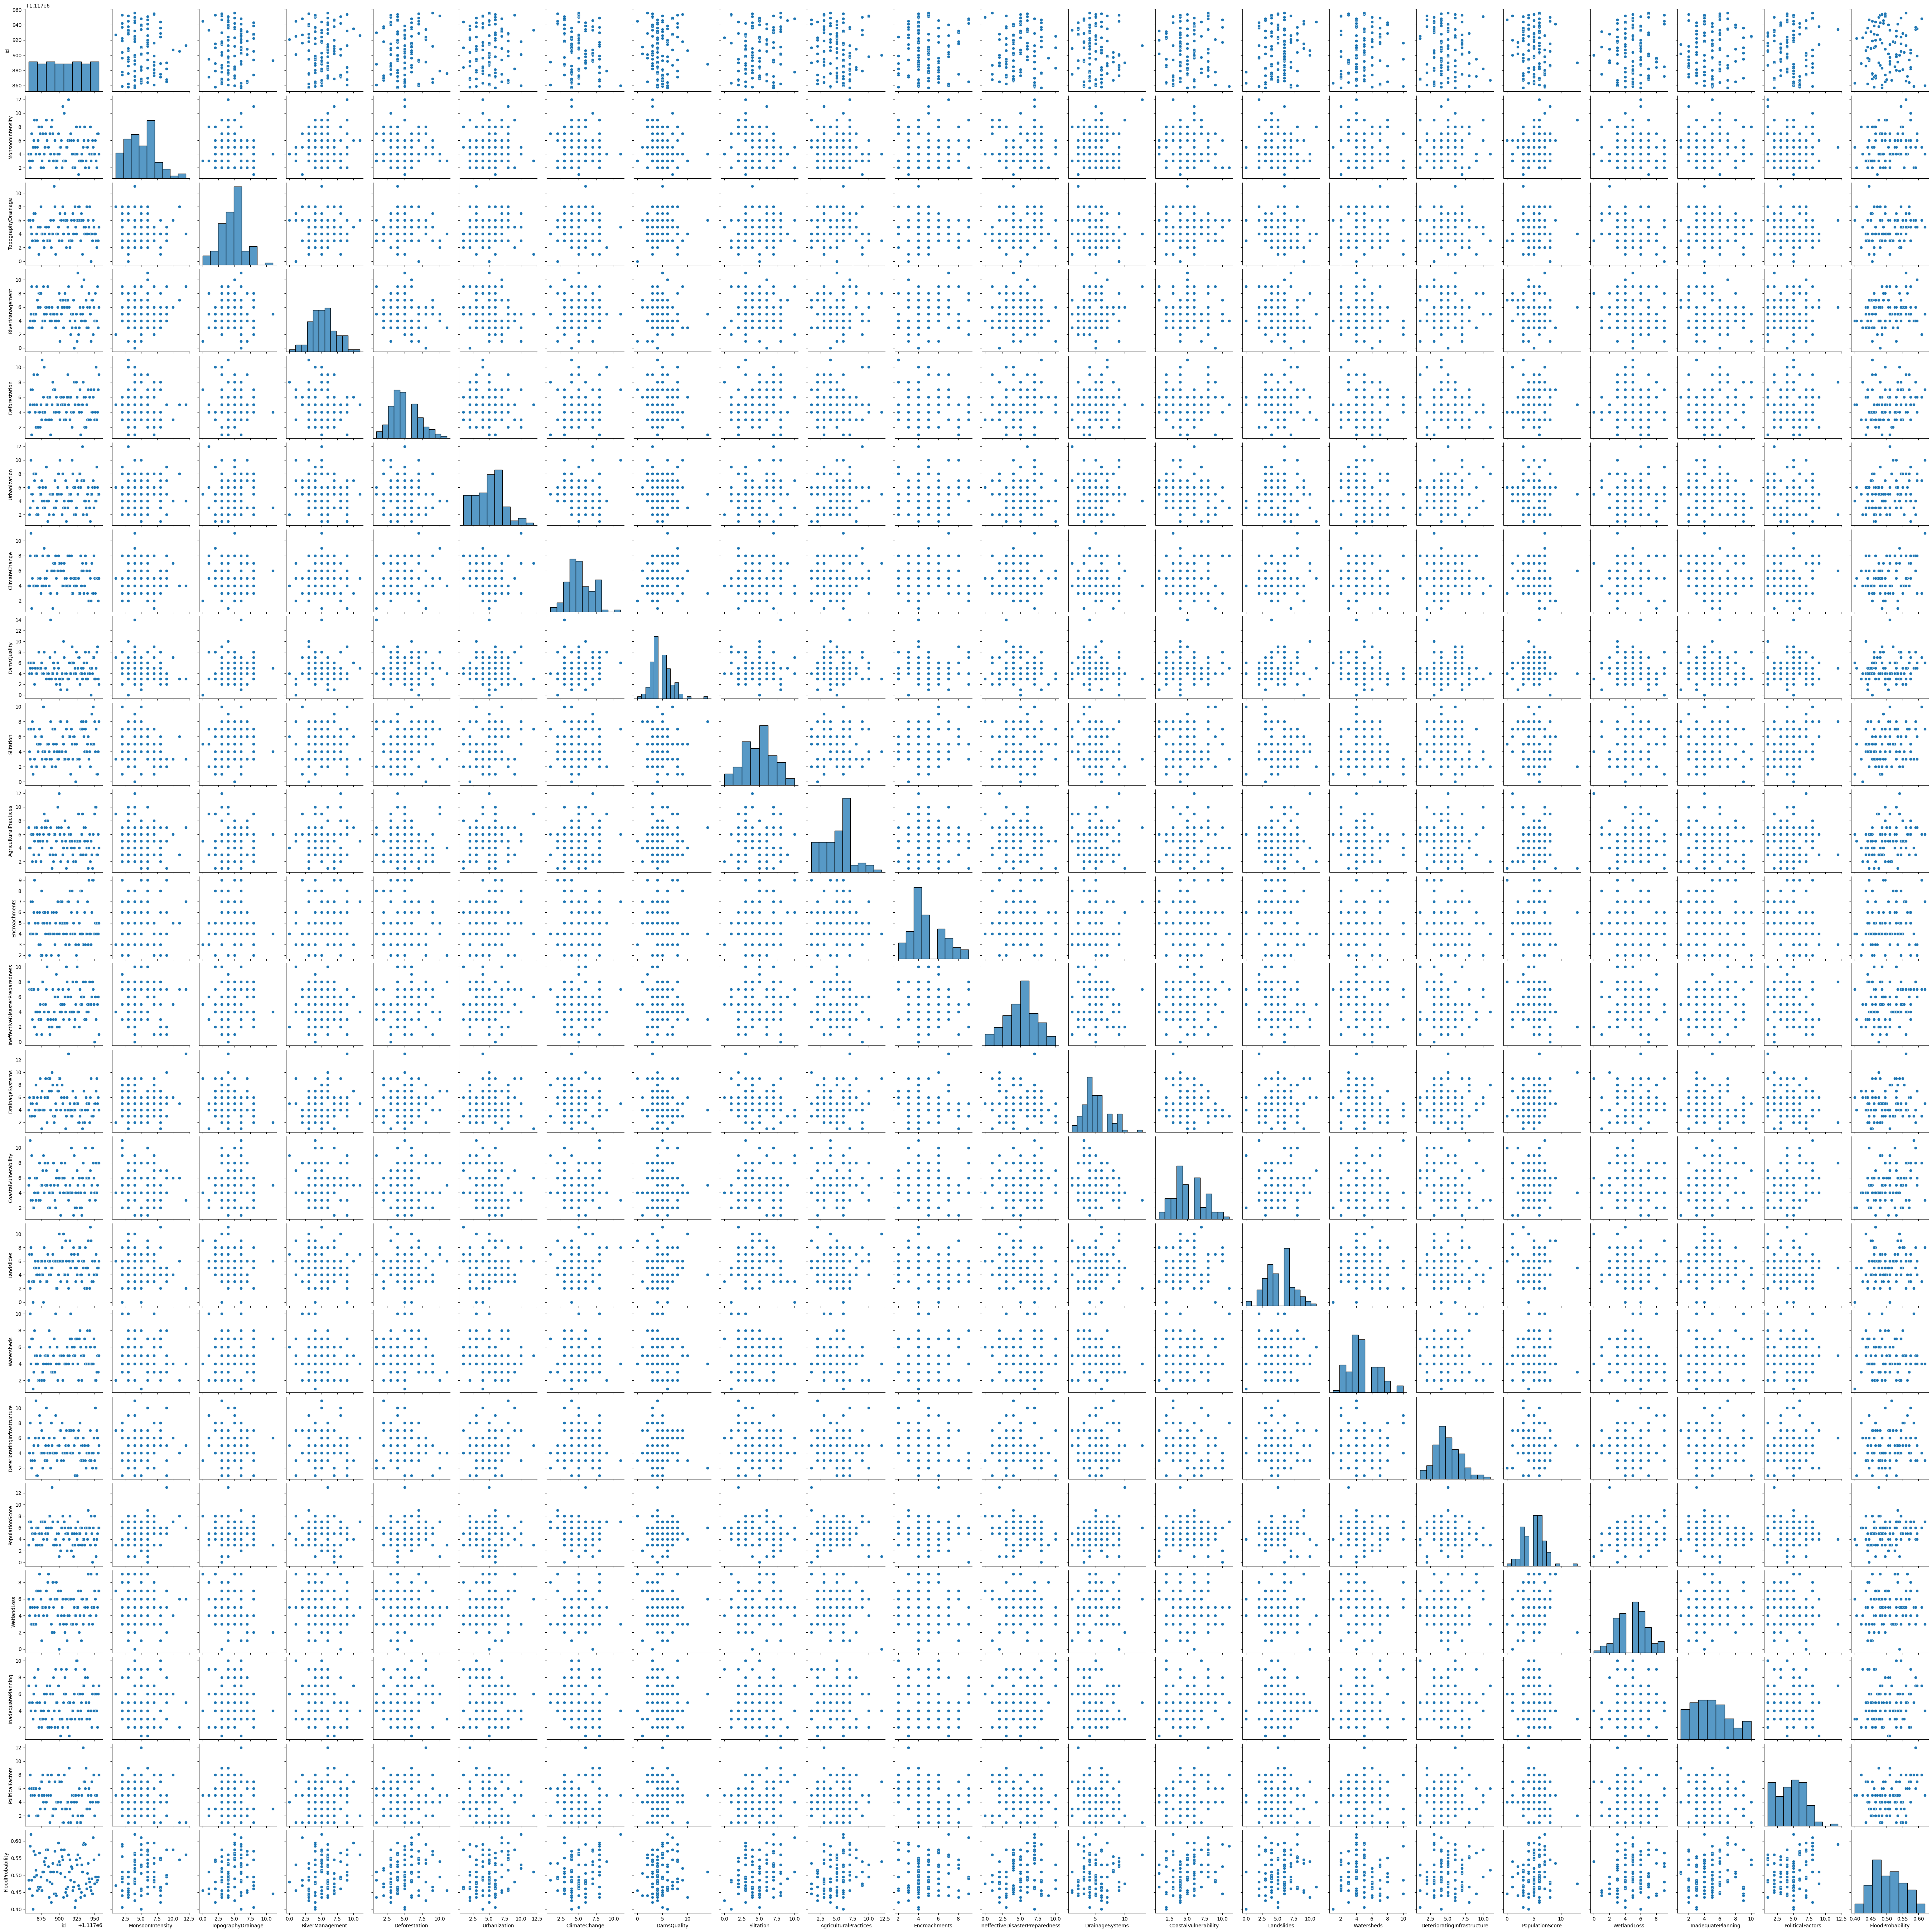

In [6]:
sns.pairplot(df[-100:])

It seems that there is not direct correlation from one variable to the flood probability

In [9]:
def get_train_test_sample_from_raw_df(dataset):
    y = df.FloodProbability
    X = df.drop(['FloodProbability', 'id'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

## XGBoost

## Baseline with XGBoost 

In [10]:
def score_valid(X_train, X_valid, y_train, y_valid):
    model=XGBRegressor(n_jobs=4, verbosity=2, random_state=1, early_stopping_rounds = 5)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose = False)
    y_pred = model.predict(X_valid)
    r2 = r2_score(y_valid, y_pred)
    print(f"R2 Score: {r2}")
    # Get feature importances
    importances = model.feature_importances_
    print(importances)
    
    # Plot feature importances
    plot_importance(model)
    plt.show()
    return model

In [11]:
X_train, X_test, y_train, y_test = get_train_test_sample_from_raw_df(df)
model_baseline = score_valid(X_train, X_test, y_train, y_test)

R2 Score: 0.8090669608359393
[0.04513352 0.04902912 0.05000903 0.05216301 0.05147357 0.04996126
 0.04829189 0.0457877  0.04875236 0.04812667 0.04430217 0.04972836
 0.04442737 0.05528155 0.04412579 0.05575489 0.05440342 0.05985231
 0.04964871 0.05374735]


Using a simple XGBoost algorithm with no fine tunning, we get a R2 score of 0.8090669608359393

### Feature engineering

Let's do some feature engineering
The idea is to substitute the data by their metadata.

In [23]:
def generate_features(X_dataset):
    features = ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors']
    
    dataset = X_dataset.copy()
    dataset['mean_features'] = 0.1*dataset[features].mean(axis=1)
    dataset['std_features'] = dataset[features].std(axis=1)
    dataset['max_features'] = dataset[features].max(axis=1)
    #dataset['min_features'] = dataset[features].min(axis=1)
    dataset['median_features'] = 0.1*dataset[features].median(axis=1)
    #dataset['range_features'] = dataset['max_features'] - dataset['min_features']
    dataset['variance_features'] = dataset[features].var(axis=1)
    dataset['skewness_features'] = dataset[features].skew(axis=1)
    
    quartiles = dataset[features].quantile([0.25, 0.5, 0.75], axis=1)
    dataset['first_quartile'] = quartiles.loc[0.25]
    dataset['second_quartile'] = quartiles.loc[0.5]
    dataset['third_quartile'] = quartiles.loc[0.75]
    
    kurtosis_features = dataset[features].kurtosis(axis=1)
    #dataset['kurtosis_features'] = kurtosis_features
    
    selected_columns = ['Urbanization', 'Deforestation', 'AgriculturalPractices', 'InadequatePlanning']
    #dataset['Sum_Selected_Columns'] = dataset[selected_columns].sum(axis=1)
    
    #dataset['Urbanization_Deforestation_Interaction'] = dataset['Urbanization'] * dataset['Deforestation']
    #dataset['Urbanization_TopographyDrainage_Ratio'] = dataset['Urbanization'] / (dataset['TopographyDrainage'] + 1)
    
    dataset.drop(features, axis=1, inplace=True)
    
    return dataset

In [14]:
X_train, X_test, y_train, y_test = get_train_test_sample_from_raw_df(df)
featured_X_train = generate_features(X_train)
featured_X_test = generate_features(X_test)

R2 Score: 0.8687175887331562
[9.8730361e-01 2.0268760e-03 6.8898923e-03 9.6284889e-04 0.0000000e+00
 1.0942632e-03 7.3086785e-04 0.0000000e+00 9.9164934e-04]


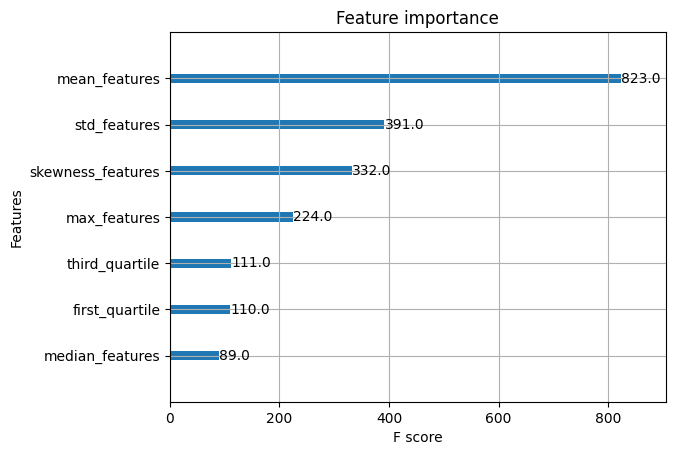

In [45]:
model_featured = score_valid(featured_X_train, featured_X_test, y_train, y_test)

Using the meta data of the dataset the R2 score increased to 0.8687175887331562
It also seems that the mean is the most important parameter. Let's check it

In [16]:
plt.plot(list(featured_X_train['mean_features'][:1000]), list(y_train[:1000]), 'go' )

It looks like now there is a linear correlation between flood probability and mean of data distribution

### Principal Component Analysis PCA

Let's try to apply PCA on the dataset

In [17]:
X_train, X_test, y_train, y_test = get_train_test_sample_from_raw_df(df)
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [18]:
X_train_pca[0], X_test_pca[0]

(array([ 2.56969017,  1.60410657,  2.8345571 ,  2.37919911, -0.8237274 ,
        -3.46254013,  4.32264251,  5.64274636, -1.98774405, -0.19759509,
        -0.059008  ,  2.23545362, -0.08090601, -1.25098573,  1.65590341,
        -3.1738831 , -0.31271083,  3.34958885,  0.04954728,  2.78490026]),
 array([ 1.18160863,  1.03566281, -3.91253736, -0.76821979, -1.33861006,
         1.48062892, -1.27724317,  3.23872927, -1.9903444 ,  0.8693195 ,
        -1.32539384,  3.9956236 , -2.38770612, -0.42467314, -1.65957118,
        -3.31328002, -0.44824705,  1.35544857, -1.44651568,  1.23790565]))

In [19]:
pca.explained_variance_ratio_*100

array([5.15625179, 5.15493856, 5.12835315, 5.11108106, 5.10696584,
       5.09789073, 5.08659773, 5.07330916, 5.06798923, 5.05627427,
       5.05413837, 5.03091456, 5.02628686, 5.01246382, 5.00024733,
       4.98697909, 4.96851358, 4.9489612 , 4.92658791, 4.00525574])

It seems that none of the new characteristics explains better the new data.

R2 Score: 0.8609699019366402
[8.6129137e-04 6.0602347e-03 2.5814699e-03 4.3287398e-03 2.5683062e-03
 2.4933892e-03 3.4280743e-03 1.1015411e-03 1.1470815e-03 1.1712878e-03
 2.9050307e-03 1.9347975e-03 3.1260166e-03 1.1621251e-03 2.7694514e-03
 1.1983560e-03 1.8073557e-03 6.1664903e-03 4.6301670e-03 9.4855881e-01]


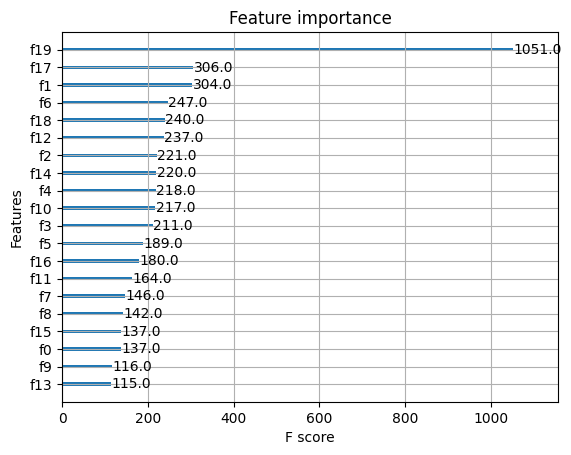

In [20]:
model_pca = score_valid(X_train_pca, X_test_pca, y_train, y_test)

## CatBoost

## Baseline model

In [13]:
X_train, X_test, y_train, y_test = get_train_test_sample_from_raw_df(df)
train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)

In [15]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [ ]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

In [21]:
pred = model.predict(X_test)
r2 = r2_score(y_test, pred)
print('Testing performance')
print('R2: {:.2f}'.format(r2))

Testing performance
R2: 0.84


## Featured model

In [25]:
X_train, X_test, y_train, y_test = get_train_test_sample_from_raw_df(df)
featured_X_train = generate_features(X_train)
featured_X_test = generate_features(X_test)
train_featured_dataset = cb.Pool(featured_X_train, y_train)
test_featured_dataset = cb.Pool(featured_X_test, y_test)

In [26]:
model_featured_cb = cb.CatBoostRegressor(loss_function='RMSE')
model_featured_cb.grid_search(grid, train_featured_dataset)

0:	learn: 0.4918818	test: 0.4920665	best: 0.4920665 (0)	total: 15.2ms	remaining: 1.5s
1:	learn: 0.4772241	test: 0.4774053	best: 0.4774053 (1)	total: 24.7ms	remaining: 1.21s
2:	learn: 0.4630089	test: 0.4631872	best: 0.4631872 (2)	total: 33.2ms	remaining: 1.07s
3:	learn: 0.4492071	test: 0.4493819	best: 0.4493819 (3)	total: 41.5ms	remaining: 997ms
4:	learn: 0.4358430	test: 0.4360186	best: 0.4360186 (4)	total: 50.1ms	remaining: 952ms
5:	learn: 0.4228427	test: 0.4230118	best: 0.4230118 (5)	total: 58.9ms	remaining: 923ms
6:	learn: 0.4102240	test: 0.4103913	best: 0.4103913 (6)	total: 67ms	remaining: 890ms
7:	learn: 0.3980300	test: 0.3981978	best: 0.3981978 (7)	total: 75.1ms	remaining: 864ms
8:	learn: 0.3861607	test: 0.3863237	best: 0.3863237 (8)	total: 83.2ms	remaining: 841ms
9:	learn: 0.3746730	test: 0.3748329	best: 0.3748329 (9)	total: 91.1ms	remaining: 820ms
10:	learn: 0.3635025	test: 0.3636582	best: 0.3636582 (10)	total: 99.7ms	remaining: 807ms
11:	learn: 0.3526945	test: 0.3528517	best: 0

{'params': {'depth': 8,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2,
  'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [43]:
pred = model_featured_cb.predict(featured_X_test)
r2 = r2_score(y_test, pred)
print('Testing performance')
print(f'R2: {r2}')

Testing performance
R2: 0.8685801792863252


## Submission

In [31]:
sub_df = pd.read_csv('./test.csv')

In [38]:
sub_df.head()

id  MonsoonIntensity  TopographyDrainage  RiverManagement  \
0  1117957                 4                   6                3   
1  1117958                 4                   4                2   
2  1117959                 1                   3                6   
3  1117960                 2                   4                4   
4  1117961                 6                   3                2   

   Deforestation  Urbanization  ClimateChange  DamsQuality  Siltation  \
0              5             6              7            8          7   
1              9             5              5            4          7   
2              5             7              2            4          6   
3              6             4              5            4          3   
4              4             6              4            5          5   

   AgriculturalPractices  ...  IneffectiveDisasterPreparedness  \
0                      8  ...                                8   
1                      5  ...                                2   
2                      4  ...                                7   
3                      4  ...                                7   
4                      3  ...                                4   

   DrainageSystems  CoastalVulnerability  Landslides  Watersheds  \
0                5                     7           5           6   
1                4                     7           4           5   
2                9                     2           5           5   
3                8                     4           6           7   
4                3                     2           6           4   

   DeterioratingInfrastructure  PopulationScore  WetlandLoss  \
0                            3                6            4   
1                            1                7            4   
2                            2                3            6   
3                            6                4            2   
4                            6                8            4   

   InadequatePlanning  PoliticalFactors  
0                   4                 5  
1                   4                 3  
2                   8                 3  
3                   4                 4  
4                   5                 5  

[5 rows x 21 columns]

In [33]:
X = sub_df.drop(['id'], axis=1)

In [34]:
X_featured = generate_features(X)

In [46]:
predict_probs = model_featured.predict(X_featured)

In [47]:
sub=pd.DataFrame({
    'id':sub_df['id'],
    'FloodProbability':predict_probs
})


In [48]:
sub.to_csv('submission.csv',index = False)